Análisis de atributos protegidos con fairlearn
==============================================


## ¿Que significa que un modelo sea justo?

A medida que los modelos predictivos de Machine Learning avanzan más y más en nuestro día a día para decidir, informar y también actuar sobre nuestras vidas, muchas preguntas se nos aparecen sobre qué tan “justas” son tales decisiones que los sistemas toman. De particular interés es el evitar que estas decisiones terminen afectando a grupos minoritarios de forma inequitativa discriminando por género, raza, religión, etc.

Un sistema basado en modelos de aprendizaje automático puede comportarse de manera injusta ante sus usuarios por diversas razones. A veces se debe a sesgos sociales reflejados en los datos de entrenamiento y en las decisiones tomadas durante el desarrollo. En otros casos, los sistemas se comportan injustamente no por sesgos sociales, sino por las características de los datos (por ejemplo, muy pocos datos sobre algún grupo de personas en particular). Puede ser difícil distinguir entre estas razones, especialmente porque no son mutuamente excluyentes y, a menudo, se exacerban entre sí.

Por lo tanto, definimos si un modelo de aprendizaje automático se está comportando injustamente en términos de su impacto en las personas, es decir, en términos de daños, y no en términos de causas específicas, como sesgos sociales, o en términos de intenciones, como prejuicios.

> Para una análisis más profundo sobre este tema puede ver el artículo: [¿Qué significa que un modelo sea justo?](https://santiagof.medium.com/qu%C3%A9-significa-que-un-modelo-sea-justo-793be6741b95)

## ¿Que es fairlearn?

fairlearn es un paquete de Python que puede ayudar a evaluar y mitigar la no imparcialidad en los modelos de aprendizaje automático. Sin embargo, no pierda de vista que la equidad es un desafío fundamentalmente sociotécnico y no se puede resolver solo con herramientas tecnológicas. Dicho esto, fairlearn puede ser útil para ciertas tareas, como evaluar la injusticia a través de varias métricas, o para mitigar la injusticia observada al entrenar un modelo.

Instalamos la librerias necesarias

In [1]:
!wget https://raw.githubusercontent.com/santiagxf/E72102/master/docs/develop/modeling/selection/code/fairlearn.txt \
    --quiet --no-clobber
!pip install -r fairlearn.txt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.5/231.5 kB 2.7 MB/s eta 0:00:00


## Utilizando fairlearn en el problema censo de la UCI

### Sobre el conjunto de datos del censo UCI

El conjunto de datos del censo de la UCI es un conjunto de datos en el que cada registro representa a una persona. Cada registro contiene 14 columnas que describen a una una sola persona, de la base de datos del censo de Estados Unidos de 1994. Esto incluye información como la edad, el estado civil y el nivel educativo. La tarea es determinar si una persona tiene un ingreso alto (definido como ganar más de $50 mil al año). Esta tarea, dado el tipo de datos que utiliza, se usa a menudo en el estudio de equidad, en parte debido a los atributos comprensibles del conjunto de datos, incluidos algunos que contienen tipos sensibles como la edad y el género, y en parte también porque comprende una tarea claramente del mundo real.

Descargamos el conjunto de datos

In [2]:
!wget https://santiagxf.blob.core.windows.net/public/datasets/uci_census.zip \
    --quiet --no-clobber
!mkdir -p datasets/uci_census
!unzip -qq uci_census.zip -d datasets/uci_census

En este ejemplo, utilizaremos el modelo entrenado en uno de los ejercicios anteriores. Para simplificar el proceso, las predicciones del modelo se cargaron y agregaron directamente en el archivo `adult-test-scored.csv`:

In [4]:
import pandas as pd

scored_dataset = pd.read_csv('datasets/uci_census/data/adult-test-scored.csv')

In [5]:
scored_dataset.head(5)

,Unnamed: 0,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income,score
0,0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,<=50K
1,1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,<=50K
2,2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,<=50K
3,3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,<=50K
4,4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,<=50K


Note como las predicciones del modelo están en la columna `score`.

### Utilizando métricas para identificar paridades

Podemos utilizar algunas métricas para identificar disparidades que se encuentran directamente en nuestro conjunto de datos:

- `selection_rate`: Calcula la fracción de predicciones que coninciden con el resultado "positivo"

Primero, convertimos la variable en la que estamos interesados en computar una métrica en numérica:

In [6]:
y_true = (scored_dataset['income'] == '>50K') * 1

Luego, seleccionamos el atributo que queremos discriminar:

In [7]:
gender = scored_dataset['gender']

Finalmente, computamos la métrica.

> Note como estamos configurando `y_true` y `y_pred` con los mismos valores. Esto lo hacemos porque estamos interesados en saber cúal es el sezgo original en el conjunto de datos (no en el modelo).

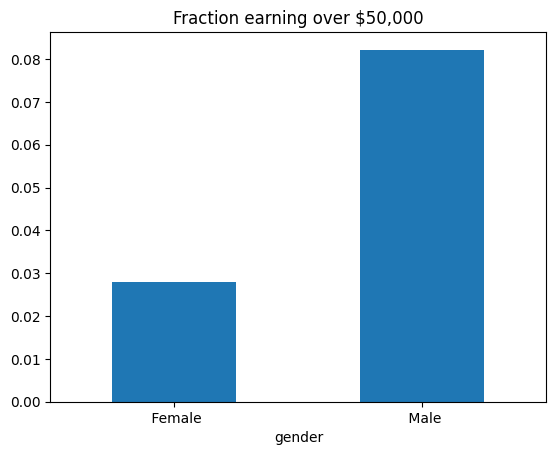

In [8]:
from fairlearn.metrics import MetricFrame, selection_rate

selection_rates = MetricFrame(metrics=selection_rate,
                              y_true=y_true,
                              y_pred=y_true,
                              sensitive_features=gender)

fig = selection_rates.by_group.plot.bar(
    legend=False, rot=0,
    title='Fraction earning over $50,000')

Podemos ver en el gráfico anterior que los hombres tienen una probabilidad más alta de ser seleccionados con la etiqueta de `> 50K` que las mujeres. Esto no significa que nuestro modelo efectivamente copie este sezgo. Sin embargo, nos da la pauta de que el modelo podría estar incentivado a copiarlo simplemente al intentar optimizar la métrica de performance sobre el conjunto de datos.

In [9]:
selection_rates.difference()

0.05434109974137632

### Evaluando la imparcialidad de un modelo

Veamos como podemos evaluar la imparcialidad de un modelo al seleccionar atributos donde estamos interesados que el modelo no tenga sezgos. Al igual que hicimos anteriormente, necesitamos seleccionar el atributo que queremos explorar:

In [ ]:
gender = scored_dataset['gender']

Necesitamos las categorias codificadas de forma numerica para trabajar con las métricas de aquí en adelante:

In [ ]:
y_pred = (scored_dataset['score'] == '>50K') * 1
y_true = (scored_dataset['income'] == '>50K') * 1

Calculamos la métrica `accuracy`

In [ ]:
from sklearn.metrics import accuracy_score

gm = MetricFrame(metrics=accuracy_score, y_true=y_true, y_pred=y_pred, sensitive_features=gender)

En general, el modelo tiene la siguiente performance según la métrica `accuracy`

In [ ]:
print(gm.overall)

0.821012868155155


Sin embargo, si examinamos la métrica para cada grupo, el valor no es el mismo:

In [ ]:
print(gm.by_group)

gender
 Female    0.917278
 Male      0.773428
Name: accuracy_score, dtype: float64


Además, fairlearn tiene muchas otras métricas integradas, como la tasa de selección, es decir, el porcentaje de la población que tiene "1" como etiqueta:

In [ ]:
from fairlearn.metrics import selection_rate

selection_rates = MetricFrame(metrics=selection_rate,
                              y_true=y_true,
                              y_pred=y_pred,
                              sensitive_features=gender)
print(selection_rates.overall)

0.06421792942477196


In [ ]:
print(selection_rates.by_group)

gender
 Female    0.027853
 Male      0.082194
Name: selection_rate, dtype: float64


Podemos rápidamente graficar estos valores junto con otras métricas interesantes:

array([[<Axes: title={'center': 'accuracy'}, xlabel='gender'>,
        <Axes: title={'center': 'precision'}, xlabel='gender'>,
        <Axes: title={'center': 'recall'}, xlabel='gender'>],
       [<Axes: title={'center': 'false positive rate'}, xlabel='gender'>,
        <Axes: title={'center': 'true positive rate'}, xlabel='gender'>,
        <Axes: title={'center': 'selection rate'}, xlabel='gender'>],
       [<Axes: title={'center': 'count'}, xlabel='gender'>,
        <Axes: xlabel='gender'>, <Axes: xlabel='gender'>]], dtype=object)

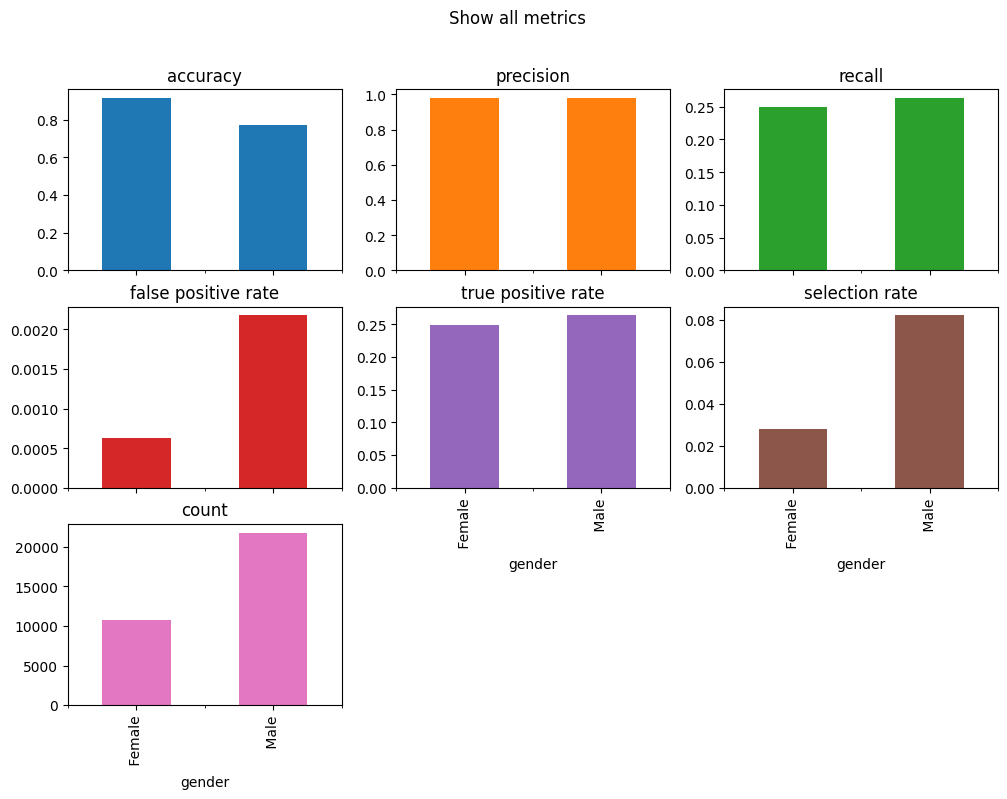

In [ ]:
from fairlearn.metrics import *
from sklearn.metrics import accuracy_score, precision_score, recall_score

metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'false positive rate': false_positive_rate,
    'true positive rate': true_positive_rate,
    'selection rate': selection_rate,
    'count': count}

metric_frame = MetricFrame(metrics=metrics,
                           y_true=y_true,
                           y_pred=y_pred,
                           sensitive_features=gender)

metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

#### Métricas personalizadas

<div class="admonition warning">PRECAUCIÓN 😱: El tema presentado en esta sección está clasificado como avanzado. El entendimiento de este contenido es totalmente opcional.</div>

En muchos casos, las métricas que queremos computar no estan en alguna librería predefinida o simplemente están muy ligadas a nuestro negocio. En tales casos, podemos computar nuestras propias métricas.

En el siguiente ejemplo, mostraremos como computar el error asociado con una métrica que computamos para tener en cuenta el intervalo de confianza de la misma. Scikit-learn dispone de la métrica `balanced_accuracy_score`, pero no dispone de una forma de computar su error. En este ejemplo agregaremos una métrica llamada `balanced_accuracy_error`:

> Adaptado de: https://fairlearn.org/v0.9/auto_examples/plot_credit_loan_decisions.html#mitigating-unfairness-in-ml-models

In [16]:
import numpy as np
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

def compute_error_metric(metric_value, sample_size):
    """Compute standard error of a given metric based on the assumption of
    normal distribution.

    Parameters:
    metric_value: Value of the metric
    sample_size: Number of data points associated with the metric

    Returns:
    The standard error of the metric
    """
    metric_value = metric_value / sample_size
    return (
        1.96
        * np.sqrt(metric_value * (1.0 - metric_value))
        / np.sqrt(sample_size)
    )

def false_positive_error(y_true, y_pred):
    """Compute the standard error for the false positive rate estimate."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return compute_error_metric(fp, tn + fp)


def false_negative_error(y_true, y_pred):
    """Compute the standard error for the false negative rate estimate."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return compute_error_metric(fn, fn + tp)


def balanced_accuracy_error(y_true, y_pred):
    """Compute the standard error for the balanced accuracy estimate."""
    fpr_error, fnr_error = false_positive_error(
        y_true, y_pred
    ), false_negative_error(y_true, y_pred)
    return np.sqrt(fnr_error**2 + fpr_error**2) / 2

Una vez que tenemos las funciones definidas, simplemente creamos un diccionario con las métricas que queremos usar, agregando nuestra nueva métrica `balanced_accuracy_error`:

In [20]:
metrics = {
    "balanced_accuracy": balanced_accuracy_score,
    "balanced_acc_error": balanced_accuracy_error,
    "selection_rate": selection_rate,
}

Construimos nuestro `MetricFrame` de la misma forma que hicimos anteriormente:

In [21]:
metric_frame = MetricFrame(
    metrics=metrics,
    y_true=y_true,
    y_pred=y_pred,
    sensitive_features=gender
)

Podemos ver como la métrica se computo para cada groupo:

In [34]:
metric_frame.by_group

,balanced_accuracy,balanced_acc_error,selection_rate
gender,,,
Female,0.624369,0.012351,0.027853
Male,0.630852,0.005305,0.082194


Para visualizar mas efectivamente la métrica, utilizaremos esta función:

In [29]:
def plot_group_metrics_with_error_bars(metricframe, metric, error_name):
    """Plot the disaggregated metric for each group with an associated
    error bar. Both metric and the error bar are provided as columns in the
    provided MetricFrame.

    Parameters
    ----------
    metricframe : MetricFrame
        The MetricFrame containing the metrics and their associated
        uncertainty quantification.
    metric : str
        The metric to plot
    error_name : str
        The associated standard error for each metric in metric

    Returns
    -------
    Matplotlib Plot of point estimates with error bars
    """
    import matplotlib.pyplot as plt

    grouped_metrics = metricframe.by_group
    point_estimates = grouped_metrics[metric]
    error_bars = grouped_metrics[error_name]
    lower_bounds = point_estimates - error_bars
    upper_bounds = point_estimates + error_bars

    x_axis_names = [
        str(name) for name in error_bars.index.to_flat_index().tolist()
    ]
    plt.vlines(
        x_axis_names,
        lower_bounds,
        upper_bounds,
        linestyles="dashed",
        alpha=0.45,
    )
    plt.scatter(x_axis_names, point_estimates, s=25)
    plt.xticks(rotation=0)
    y_start, y_end = np.round(min(lower_bounds), decimals=2), np.round(
        max(upper_bounds), decimals=2
    )
    plt.ylabel(metric)

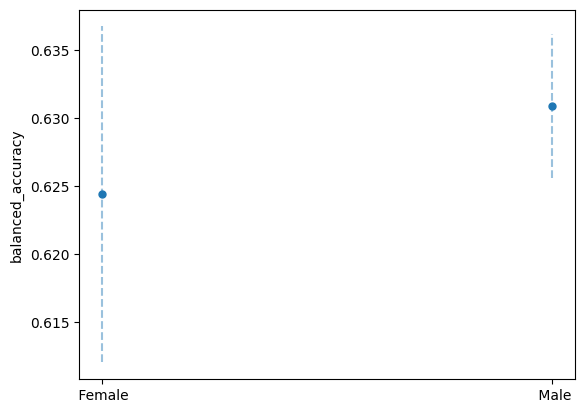

In [30]:
plot_group_metrics_with_error_bars(
    metric_frame, "balanced_accuracy", "balanced_acc_error"
)